# Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt


from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
)
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, MultiLabelBinarizer
)


import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Lectura de datos

In [2]:
df_games=pd.read_csv("./converted.csv")
df_games.sort_values(by="AppID", inplace=True)
df_games["AppID"]=df_games["AppID"].astype(str)

In [3]:
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

# Analisis de datos

In [4]:

def parse_mixed_date(date_str):
    for fmt in ('%b %d, %Y', '%b %Y'):
        try:
            return datetime.strptime(date_str.strip(), fmt)
        except ValueError:
            continue
    return pd.NaT
df_games['Release date'] = df_games['Release date'].apply(parse_mixed_date)

In [5]:
df_games

,AppID,index,Name,Release date,Required age,Price,DLC count,Detailed description,About the game,Short description,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,Achievements,Recommendations,Notes,Supported languages,Full audio languages,Packages,Developers,Publishers,Categories,Genres,Screenshots,Movies,User score,Score rank,Positive,Negative,Estimated owners,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Peak CCU,Tags,discount
39428,10,10,Counter-Strike,2000-11-01,0,9.99,0,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,http://steamcommunity.com/app/10,NaN,True,True,True,88,https://www.metacritic.com/game/pc/counter-str...,0,122770,Includes intense violence and blood.,"English,French,German,Italian,Spanish - Spain,...","English,French,German,Italian,Spanish - Spain,...","[{'title': 'Buy Counter-Strike', 'description'...",Valve,Valve,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,0,NaN,198387,5135,10000000 - 20000000,10524,1733,228,733,13230,"Action,FPS,Multiplayer,Shooter,Classic,Team-Ba...",NaN
19555,20,20,Team Fortress Classic,1999-04-01,0,4.99,0,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,NaN,True,True,True,0,NaN,0,4722,Includes intense violence and blood.,"English,French,German,Italian,Spanish - Spain,...",NaN,"[{'title': 'Buy Team Fortress Classic', 'descr...",Valve,Valve,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,0,NaN,5677,923,5000000 - 10000000,143,0,23,0,110,"Action,FPS,Multiplayer,Classic,Hero Shooter,Sh...",NaN
3636,30,30,Day of Defeat,2003-05-01,0,4.99,0,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.dayofdefeat.com/,NaN,NaN,True,True,True,79,https://www.metacritic.com/game/pc/day-of-defe...,0,3246,NaN,"English,French,German,Italian,Spanish - Spain",NaN,"[{'title': 'Buy Day of Defeat', 'description':...",Valve,Valve,"Multi-player,Valve Anti-Cheat enabled",Action,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,0,NaN,5179,566,5000000 - 10000000,1397,0,27,0,106,"FPS,World War II,Multiplayer,Shooter,Action,Wa...",NaN
34209,40,40,Deathmatch Classic,2001-06-01,0,4.99,0,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,NaN,True,True,True,0,NaN,0,1570,NaN,"English,French,German,Italian,Spanish - Spain,...",NaN,"[{'title': 'Buy Deathmatch Classic', 'descript...",Valve,Valve,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,0,NaN,1929,428,5000000 - 10000000,945,0,10,0,2,"Action,FPS,Classic,Multiplayer,Shooter,First-P...",NaN
39055,50,50,Half-Life: Opposing Force,1999-11-01,0,4.99,0,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,https://help.steampowered.com,NaN,True,True,True,0,NaN,0,12374,NaN,"English,French,German,Korean",NaN,"[{'title': 'Buy Half-Life: Opposing Force', 'd...",Gearbox Software,Valve,"Single-player,Multi-player,Valve Anti-Cheat en...",Action,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,0,NaN,14333,718,5000000 - 10000000,214,0,66,0,120,"FPS,Action,Classic,Sci-fi,Singleplayer,Shooter.

In [6]:
df_games.columns

Index(['AppID', 'index', 'Name', 'Release date', 'Required age', 'Price',
       'DLC count', 'Detailed description', 'About the game',
       'Short description', 'Reviews', 'Header image', 'Website',
       'Support url', 'Support email', 'Windows', 'Mac', 'Linux',
       'Metacritic score', 'Metacritic url', 'Achievements', 'Recommendations',
       'Notes', 'Supported languages', 'Full audio languages', 'Packages',
       'Developers', 'Publishers', 'Categories', 'Genres', 'Screenshots',
       'Movies', 'User score', 'Score rank', 'Positive', 'Negative',
       'Estimated owners', 'Average playtime forever',
       'Average playtime two weeks', 'Median playtime forever',
       'Median playtime two weeks', 'Peak CCU', 'Tags', 'discount'],
      dtype='object')

In [7]:
df_games.isna().sum()[df_games.isna().sum()>0]

Name                         6
Detailed description      6457
About the game            6483
Short description         6376
Reviews                 100828
Website                  64994
Support url              60693
Support email            19025
Metacritic url          107447
Notes                    93003
Supported languages       6434
Full audio languages     65823
Developers                6475
Publishers                6778
Categories                7566
Genres                    6440
Screenshots               4192
Movies                    9620
Score rank              111408
Tags                     37423
discount                 97410
dtype: int64

In [8]:
cols_to_drop = ['index',
    'About the game', 'Reviews', 'Website', 'Support url', 'Support email',
    'Metacritic url', 'Notes', 'Movies', 'Header image', 'Screenshots',
    'Tags', 'Full audio languages', 'discount', 'Score rank', 'Detailed description','Packages'
]
df_games.drop(columns=cols_to_drop, inplace=True)

In [9]:
df_games.isna().sum()[df_games.isna().sum()>0]

Name                      6
Short description      6376
Supported languages    6434
Developers             6475
Publishers             6778
Categories             7566
Genres                 6440
dtype: int64

In [10]:
df_games.dropna(inplace=True)

In [11]:
df_games

,AppID,Name,Release date,Required age,Price,DLC count,Short description,Windows,Mac,Linux,Metacritic score,Achievements,Recommendations,Supported languages,Developers,Publishers,Categories,Genres,User score,Positive,Negative,Estimated owners,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Peak CCU
39428,10,Counter-Strike,2000-11-01,0,9.99,0,Play the world's number 1 online action game. ...,True,True,True,88,0,122770,"English,French,German,Italian,Spanish - Spain,...",Valve,Valve,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action,0,198387,5135,10000000 - 20000000,10524,1733,228,733,13230
19555,20,Team Fortress Classic,1999-04-01,0,4.99,0,One of the most popular online action games of...,True,True,True,0,0,4722,"English,French,German,Italian,Spanish - Spain,...",Valve,Valve,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action,0,5677,923,5000000 - 10000000,143,0,23,0,110
3636,30,Day of Defeat,2003-05-01,0,4.99,0,Enlist in an intense brand of Axis vs. Allied ...,True,True,True,79,0,3246,"English,French,German,Italian,Spanish - Spain",Valve,Valve,"Multi-player,Valve Anti-Cheat enabled",Action,0,5179,566,5000000 - 10000000,1397,0,27,0,106
34209,40,Deathmatch Classic,2001-06-01,0,4.99,0,Enjoy fast-paced multiplayer gaming with Death...,True,True,True,0,0,1570,"English,French,German,Italian,Spanish - Spain,...",Valve,Valve,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action,0,1929,428,5000000 - 10000000,945,0,10,0,2
39055,50,Half-Life: Opposing Force,1999-11-01,0,4.99,0,Return to the Black Mesa Research Facility as ...,True,True,True,0,0,12374,"English,French,German,Korean",Gearbox Software,Valve,"Single-player,Multi-player,Valve Anti-Cheat en...",Action,0,14333,718,5000000 - 10000000,214,0,66,0,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111361,3633390,DECK COLLECTOR,2025-04-19,0,8.39,0,DECK COLLECTOR is an immersive collectible car...,True,False,False,0,0,0,English,AEROBORN Games,AEROBORN Games,"Single-player,Family Sharing","Casual,Indie,Simulation,Early Access",0,0,0,0 - 0,0,0,0,0,0
111288,3633540,Golden Arrow,2025-04-20,0,7.64,0,A 2d puzzle game in a world of arrows!,True,False,False,0,0,0,English,Dong Cha,Inblue games,"Single-player,Steam Cloud,Family Sharing","Casual,Indie,Strategy",0,0,0,0 - 0,0,0,0,0,0
111329,3634720,Super Yapori Minigames,2025-04-16,0,0.00,0,Super Yapori Minigames is a singleplayer game ...,True,False,False,0,0,0,"English,Portuguese - Brazil",Hayllon,The Yapori Show,Single-player,"Casual,Indie,Free To Play",0,0,0,0 - 0,0,0,0,0,0
111412,3638430,CHEER SQUAD,2025-04-18,0,2.99,0,Shoot for the stars and help Latte train in he...,True,False,False,0,0,0,English,Chamber Software L.L.C.,Chamber Software L.L.C.,"Single-player,Family Sharing","Action,Indie",0,0,0,0 - 20000,0,0,0,0,0


In [12]:
duplicados=df_games['Name'].value_counts()
duplicados[duplicados>0]

Name
Shadow of the Tomb Raider: Definitive Edition    20
Alone                                             6
Dodge                                             5
The Tower                                         5
Escape                                            5
                                                 ..
Barro F25                                         1
Dungemon                                          1
SAYONALAIKA                                       1
People and Zombies                                1
Team Fortress Classic                             1
Name: count, Length: 102059, dtype: int64

# Transformación de datos

In [13]:
# Separar columnas numéricas y no numéricas
num_cols = df_games.select_dtypes(include='number').columns
non_num_cols = df_games.select_dtypes(exclude='number').columns

# Agrupar y aplicar funciones diferentes a cada tipo de columna
df_agg = df_games.groupby('Name', as_index=False).agg({
    **{col: 'first' for col in non_num_cols if col != 'Name'},  # primer valor para texto (excepto Name)
    **{col: 'mean' for col in num_cols}                         # promedio para numéricos
})


In [14]:
df_agg["Price"].describe()

count    102059.000000
mean          7.399139
std          12.428876
min           0.000000
25%           0.990000
50%           4.990000
75%           9.990000
max         999.980000
Name: Price, dtype: float64

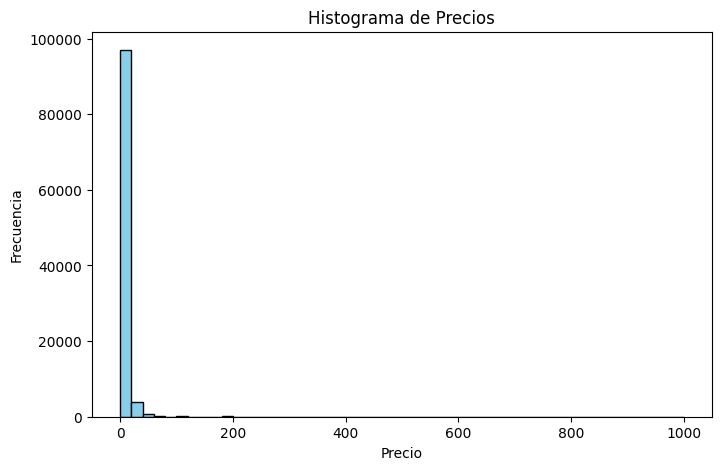

In [15]:


plt.figure(figsize=(8, 5))
plt.hist(df_agg["Price"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios')
plt.show()

In [16]:
df_agg=df_agg[df_agg["Price"]<=110]

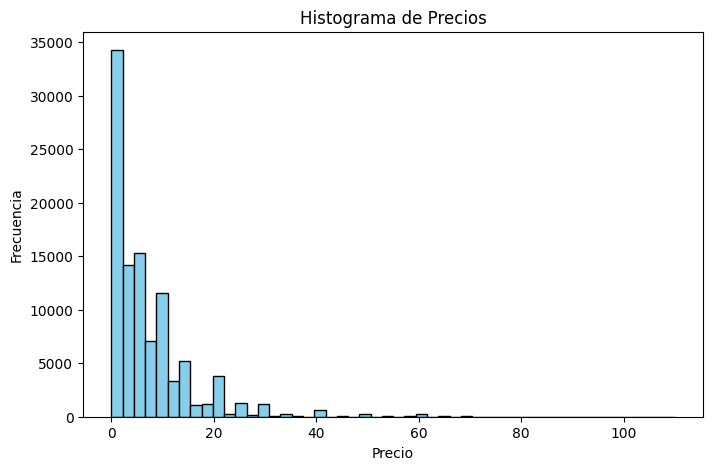

In [17]:

plt.figure(figsize=(8, 5))
plt.hist(df_agg["Price"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios')
plt.show()

In [18]:

# Convertir la columna de idiomas a listas de idiomas
langs_split = df_agg['Supported languages'].str.split(',')

# Contar frecuencia de cada idioma
lang_counts = Counter(lang for langs in langs_split for lang in set(langs))

# Umbral del 30%
threshold = 0.2 * len(df_agg)
main_langs = {lang for lang, count in lang_counts.items() if count >= threshold}

# Función para agrupar idiomas poco frecuentes en 'Other'
def filter_langs(langs):
    return [lang if lang in main_langs else 'Other_lan' for lang in langs]

langs_filtered = langs_split.apply(filter_langs)

# MultiLabelBinarizer
mlb = MultiLabelBinarizer()
langs_binarized = mlb.fit_transform(langs_filtered)

# Crear DataFrame con los resultados
langs_df = pd.DataFrame(langs_binarized, columns=mlb.classes_, index=df_agg.index)

# Concatenar al DataFrame original si se desea
df_agg_langs = pd.concat([df_agg, langs_df], axis=1)

In [19]:

# Procesar Genres
genres_split = df_agg['Genres'].str.split(',')
genre_counts = Counter(genre for genres in genres_split for genre in set(genres))
genre_threshold = 0.06 * len(df_agg)
main_genres = {genre for genre, count in genre_counts.items() if count >= genre_threshold}

def filter_genres(genres):
    return [genre if genre in main_genres else 'Other_genre' for genre in genres]

genres_filtered = genres_split.apply(filter_genres)
mlb_genres = MultiLabelBinarizer()
genres_binarized = mlb_genres.fit_transform(genres_filtered)
genres_df = pd.DataFrame(genres_binarized, columns=mlb_genres.classes_, index=df_agg.index)

# Procesar Categories
categories_split = df_agg['Categories'].str.split(',')
cat_counts = Counter(cat for cats in categories_split for cat in set(cats))
cat_threshold = 0.12 * len(df_agg)
main_cats = {cat for cat, count in cat_counts.items() if count >= cat_threshold}

def filter_cats(cats):
    return [cat if cat in main_cats else 'Other_cat' for cat in cats]

cats_filtered = categories_split.apply(filter_cats)
mlb_cats = MultiLabelBinarizer()
cats_binarized = mlb_cats.fit_transform(cats_filtered)
cats_df = pd.DataFrame(cats_binarized, columns=mlb_cats.classes_, index=df_agg.index)

# Concatenar los resultados al DataFrame original
df_agg_full = pd.concat([df_agg, genres_df, cats_df], axis=1)

In [20]:
df_agg_full.drop(columns=['Supported languages', 'Genres', 'Categories', 'Name'], inplace=True)

In [21]:
# Para Developers
dev_counts = df_agg['Developers'].value_counts()
main_devs = set(dev_counts[dev_counts >= 120].index)
df_agg['Developers_filtered'] = df_agg['Developers'].apply(lambda x: x if x in main_devs else 'Others')
dev_dummies = pd.get_dummies(df_agg['Developers_filtered'], prefix='dev')

# Para Publishers
pub_counts = df_agg['Publishers'].value_counts()
main_pubs = set(pub_counts[pub_counts >= 150].index)
df_agg['Publishers_filtered'] = df_agg['Publishers'].apply(lambda x: x if x in main_pubs else 'Others')
pub_dummies = pd.get_dummies(df_agg['Publishers_filtered'], prefix='pub')

# Concatenar los resultados al DataFrame original
df_agg_devs_pubs = pd.concat([df_agg_full, dev_dummies, pub_dummies], axis=1)

In [22]:
df_agg_devs_pubs.drop(columns=['Developers', 'Publishers', 'DLC count'], inplace=True)

In [23]:
df_agg_devs_pubs

,AppID,Release date,Short description,Windows,Mac,Linux,Estimated owners,Required age,Price,Metacritic score,Achievements,Recommendations,User score,Positive,Negative,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Peak CCU,Action,Adventure,Casual,Early Access,Free to Play,Indie,Other_genre,RPG,Simulation,Strategy,Family Sharing,Full controller support,Multi-player,Other_cat,Partial Controller Support,Single-player,Steam Achievements,Steam Cloud,dev_Boogygames Studios,dev_Choice of Games,dev_Creobit,dev_EroticGamesClub,dev_Laush Dmitriy Sergeevich,dev_Others,pub_8floor,pub_Big Fish Games,pub_Choice of Games,pub_EroticGamesClub,pub_HH-Games,pub_Kagura Games,pub_Laush Studio,pub_Others,pub_SEGA,pub_Sekai Project,pub_Square Enix,pub_Strategy First,pub_Ubisoft
0,2556940,2023-10-13,A South African urban legend called the Shakab...,True,False,False,0 - 20000,0.0,14.99,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
1,449940,2016-03-03,Steal gold from the Lerpikon's dungeons! Get r...,True,False,True,20000 - 50000,0.0,2.99,0.0,0.0,0.0,0.0,26.0,62.0,354.0,0.0,388.0,0.0,1.0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
2,1287250,2020-04-28,«Wild Russia» is an open-world horror adventur...,True,False,False,0 - 20000,0.0,19.99,0.0,9.0,0.0,0.0,41.0,22.0,0.0,0.0,0.0,0.0,1.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
3,866510,2018-06-06,Do you like parkour? Dashing retro times? AnyW...,True,False,False,50000 - 100000,0.0,1.79,0.0,4997.0,285.0,0.0,246.0,113.0,353.0,0.0,359.0,0.0,13.0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
4,870990,2018-06-13,LabRpgUp is a unique J-RPG game. Travel throug...,True,False,False,0 - 20000,0.0,0.99,0.0,2021.0,0.0,0.0,21.0,27.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102054,460250,2017-02-17,Circles is an abstract puzzle game that takes ...,True,True,False,0 - 20000,0.0,2.99,76.0,8.0,0.0,0.0,83.0,8.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
102055,965340,2018-11-14,Human Rocket Person is an absurd &amp; fun pla...,True,False,False,0 - 20000,0.0,1.99,0.0,22.0,0.0,0.0,54.0,7.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
102056,806220,2018-04-21,Sidescrolling Shoot’em’up that will transport ...,True,False,False,0 - 20000,0.0,3.99,0.0,0.0,0.0,0.0,17.0,13.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
102057,576960,2018-07-19,Dive into a wild story of gangsters and crimin...,True,True,True,20000 - 50000,17.0,14.99,0.0,28.0,162.0,0.0,110.0,26.0,326.0,0.0,326.0,0.0,1.0,0,1,1,0,0,1,0,1,1,1,0,0,0,1,0,1,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False


In [24]:
df_agg_devs_pubs.drop(columns=['Median playtime two weeks','Average playtime two weeks'], inplace=True)

In [25]:
print(df_agg_devs_pubs["Average playtime forever"].value_counts())
print(df_agg_devs_pubs["Median playtime forever"].value_counts())

Average playtime forever
0.0        86919
1.0          328
2.0          124
4.0          103
3.0          102
           ...  
2777.0         1
169.5          1
777.0          1
1799.0         1
23147.0        1
Name: count, Length: 2284, dtype: int64
Median playtime forever
0.0        86919
1.0          320
2.0          123
3.0          100
4.0           98
           ...  
1684.0         1
1635.0         1
3756.0         1
6280.0         1
99108.0        1
Name: count, Length: 1973, dtype: int64


In [26]:
print(df_agg_devs_pubs["Peak CCU"].value_counts())
print(df_agg_devs_pubs["User score"].value_counts())

Peak CCU
0.0        73872
1.0         8597
2.0         3394
3.0         1927
4.0         1371
           ...  
13053.0        1
697.0          1
2262.0         1
710.0          1
5880.0         1
Name: count, Length: 1807, dtype: int64
User score
0.0      101824
100.0         5
77.0          2
46.0          2
51.0          2
95.0          2
68.0          2
80.0          2
94.0          2
84.0          2
70.0          1
98.0          1
92.0          1
61.0          1
63.0          1
59.0          1
76.0          1
69.0          1
65.0          1
78.0          1
60.0          1
97.0          1
88.0          1
82.0          1
87.0          1
53.0          1
71.0          1
66.0          1
57.0          1
48.0          1
73.0          1
55.0          1
83.0          1
Name: count, dtype: int64


In [27]:
print(df_agg_devs_pubs["Recommendations"].value_counts())
print(df_agg_devs_pubs["Metacritic score"].value_counts())

Recommendations
0.0        87009
105.0         75
116.0         72
106.0         72
101.0         71
           ...  
1726.0         1
1813.0         1
4048.0         1
16012.0        1
2281.0         1
Name: count, Length: 4189, dtype: int64
Metacritic score
0.00     97981
80.00      193
76.00      173
78.00      166
81.00      165
         ...  
14.25        1
38.50        1
36.50        1
40.50        1
32.50        1
Name: count, Length: 93, dtype: int64


In [28]:
print(df_agg_devs_pubs["Estimated owners"].value_counts())

Estimated owners
0 - 20000                68055
0 - 0                    15026
20000 - 50000             8131
50000 - 100000            3984
100000 - 200000           2617
200000 - 500000           2156
500000 - 1000000           908
1000000 - 2000000          510
2000000 - 5000000          327
5000000 - 10000000          91
10000000 - 20000000         36
20000000 - 50000000         21
50000000 - 100000000         5
100000000 - 200000000        1
Name: count, dtype: int64


In [29]:


# Eliminar posibles espacios extra
df_agg_devs_pubs['Estimated owners'] = df_agg_devs_pubs['Estimated owners'].str.strip()

# Convertir los rangos en categorías ordenadas
# Primero obtener todos los valores únicos y ordenarlos por el valor inferior del rango
def rango_inferior(rango):
    return int(rango.split(' - ')[0].replace(',', ''))

# Ordenar los rangos por su valor inferior
sorted_categories = sorted(df_agg_devs_pubs['Estimated owners'].unique(), key=rango_inferior)

# Crear categoría ordenada
df_agg_devs_pubs['Estimated owners'] = pd.Categorical(df_agg_devs_pubs['Estimated owners'], categories=sorted_categories, ordered=True)
df_agg_devs_pubs['Estimated owners'] = df_agg_devs_pubs['Estimated owners'].replace('0 - 0', '0 - 20000')


C:\Users\perez\AppData\Local\Temp\ipykernel_16840\2278245168.py:14: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [30]:
df_agg_devs_pubs["Estimated owners"].value_counts()

Estimated owners
0 - 20000                83081
20000 - 50000             8131
50000 - 100000            3984
100000 - 200000           2617
200000 - 500000           2156
500000 - 1000000           908
1000000 - 2000000          510
2000000 - 5000000          327
5000000 - 10000000          91
10000000 - 20000000         36
20000000 - 50000000         21
50000000 - 100000000         5
100000000 - 200000000        1
Name: count, dtype: int64

In [31]:
df_agg_devs_pubs["Required age"].value_counts()

Required age
0.000000     100192
17.000000       901
18.000000       343
13.000000       219
16.000000        69
10.000000        37
12.000000        35
8.500000         11
15.000000         9
6.000000          8
3.000000          8
7.000000          7
14.000000         6
21.000000         5
9.000000          4
20.000000         2
5.000000          1
1.000000          1
1.500000          1
17.500000         1
4.333333          1
4.250000          1
5.666667          1
16.500000         1
6.500000          1
3.400000          1
19.000000         1
11.000000         1
Name: count, dtype: int64

In [32]:
# Definir los rangos para 'Required age'
age_bins = [0, 6, 12, 16, 18, 100]
age_labels = ['Todas', '6+', '12+', '16+', '18+']

# Crear la columna categórica
df_agg_devs_pubs['Required age category'] = pd.cut(df_agg_devs_pubs['Required age'], bins=age_bins, labels=age_labels, right=False, include_lowest=True)
df_agg_devs_pubs.drop(columns="Required age", inplace=True)
# Mostrar la distribución de las categorías
print(df_agg_devs_pubs['Required age category'].value_counts())

Required age category
Todas    100207
16+         972
18+         351
12+         269
6+           69
Name: count, dtype: int64


In [33]:
df_agg_devs_pubs["Achievements"].value_counts()

Achievements
0.0       49117
10.0       2659
12.0       2072
20.0       1896
5.0        1823
          ...  
512.0         1
235.0         1
335.0         1
640.0         1
2220.0        1
Name: count, Length: 529, dtype: int64

In [34]:
df_agg_devs_pubs["Achievements"].describe()

count    101868.000000
mean         18.806535
std         155.593709
min           0.000000
25%           0.000000
50%           2.000000
75%          18.000000
max        9821.000000
Name: Achievements, dtype: float64

In [35]:
ach_bins = [0, 1, 40, 100, 200, 300]
ach_labels = ['Sin logros', 'Pocos', 'Moderados', 'Muchos', 'Muchisimos']

# Crear la columna categórica
df_agg_devs_pubs['Achievements_cat'] = pd.cut(df_agg_devs_pubs['Achievements'], bins=ach_bins, labels=ach_labels, right=False, include_lowest=True)
df_agg_devs_pubs.drop(columns="Achievements", inplace=True)
# Mostrar la distribución de las categoría

In [36]:
print(df_agg_devs_pubs['Achievements_cat'].value_counts())

Achievements_cat
Sin logros    49127
Pocos         43360
Moderados      7669
Muchos         1350
Muchisimos       82
Name: count, dtype: int64


In [37]:
df_agg_devs_pubs = pd.get_dummies(df_agg_devs_pubs, 
                                  columns=['Achievements_cat', 'Required age category'],  
                                  prefix={'Achievements_cat': 'Logros', 'Required age category': 'Edades'})



In [38]:
df_agg_devs_pubs

,AppID,Release date,Short description,Windows,Mac,Linux,Estimated owners,Price,Metacritic score,Recommendations,User score,Positive,Negative,Average playtime forever,Median playtime forever,Peak CCU,Action,Adventure,Casual,Early Access,Free to Play,Indie,Other_genre,RPG,Simulation,Strategy,Family Sharing,Full controller support,Multi-player,Other_cat,Partial Controller Support,Single-player,Steam Achievements,Steam Cloud,dev_Boogygames Studios,dev_Choice of Games,dev_Creobit,dev_EroticGamesClub,dev_Laush Dmitriy Sergeevich,dev_Others,pub_8floor,pub_Big Fish Games,pub_Choice of Games,pub_EroticGamesClub,pub_HH-Games,pub_Kagura Games,pub_Laush Studio,pub_Others,pub_SEGA,pub_Sekai Project,pub_Square Enix,pub_Strategy First,pub_Ubisoft,Logros_Sin logros,Logros_Pocos,Logros_Moderados,Logros_Muchos,Logros_Muchisimos,Edades_Todas,Edades_6+,Edades_12+,Edades_16+,Edades_18+
0,2556940,2023-10-13,A South African urban legend called the Shakab...,True,False,False,0 - 20000,14.99,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
1,449940,2016-03-03,Steal gold from the Lerpikon's dungeons! Get r...,True,False,True,20000 - 50000,2.99,0.0,0.0,0.0,26.0,62.0,354.0,388.0,1.0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
2,1287250,2020-04-28,«Wild Russia» is an open-world horror adventur...,True,False,False,0 - 20000,19.99,0.0,0.0,0.0,41.0,22.0,0.0,0.0,1.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
3,866510,2018-06-06,Do you like parkour? Dashing retro times? AnyW...,True,False,False,50000 - 100000,1.79,0.0,285.0,0.0,246.0,113.0,353.0,359.0,13.0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,870990,2018-06-13,LabRpgUp is a unique J-RPG game. Travel throug...,True,False,False,0 - 20000,0.99,0.0,0.0,0.0,21.0,27.0,0.0,0.0,0.0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102054,460250,2017-02-17,Circles is an abstract puzzle game that takes ...,True,True,False,0 - 20000,2.99,76.0,0.0,0.0,83.0,8.0,0.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
102055,965340,2018-11-14,Human Rocket Person is an absurd &amp; fun pla...,True,False,False,0 - 20000,1.99,0.0,0.0,0.0,54.0,7.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
102056,806220,2018-04-21,Sidescrolling Shoot’em’up that will transport ...,True,False,False,0 - 20000,3.99,0.0,0.0,0.0,17.0,13.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
102057,576960,2018-07-19,Dive into a wild story of gangsters and crimin...,True,True,True,20

In [39]:
print(df_agg_devs_pubs['Positive'].value_counts())
print(df_agg_devs_pubs['Negative'].value_counts())

Positive
0.0        32464
1.0         6633
2.0         4775
3.0         3620
4.0         3053
           ...  
28442.0        1
18629.0        1
3398.0         1
3314.0         1
2284.0         1
Name: count, Length: 4712, dtype: int64
Negative
0.0        47020
1.0         9400
2.0         5412
3.0         3583
4.0         2805
           ...  
20197.0        1
2011.0         1
3988.0         1
822.0          1
4104.0         1
Name: count, Length: 2391, dtype: int64


### Creación de la variable objetivo

In [40]:

df=df_agg_devs_pubs.copy()
# Ratio de aceptación, con cuidado para evitar división por cero
df['acceptance_ratio'] = df['Positive'] / (df['Positive'] + df['Negative'])
df['acceptance_ratio'] = df['acceptance_ratio'].fillna(0)  # si ambos son cero

# Rango medio de owners como número
def parse_owner_range(r):
    try:
        low, high = r.replace(',', '').split(' - ')
        return (int(low) + int(high)) / 2
    except:
        return 0

df['owners_avg'] = df['Estimated owners'].apply(parse_owner_range)


In [41]:
cols_to_scale = ['owners_avg', 'Peak CCU', 'Average playtime forever']
df['acceptance_norm'] = df['acceptance_ratio'].fillna(0)


# Convertir a numérico forzadamente, convirtiendo errores en NaN
df[cols_to_scale] = df[cols_to_scale].apply(pd.to_numeric, errors='coerce')

# Ahora sí: escalar con RobustScaler

scaler = RobustScaler()
df[['owners_norm', 'ccu_norm', 'playtime_norm']] = scaler.fit_transform(
    df[cols_to_scale].fillna(0)
)



In [42]:
# Funciones para penalizar puntajes bajos (<6)
user_score_adj = df['User score'].fillna(0).apply(lambda x: x / 100 if x >= 60 else 0)
metacritic_adj = df['Metacritic score'].fillna(0).apply(lambda x: x / 100 if x >= 60 else 0)

# Asignar pesos
df['popularity_score'] = (
    0.6 * df['owners_norm'] +
    0.3 * df['acceptance_norm'] +
    0.2 * df['ccu_norm'] +
    0.1 * df['playtime_norm'] +
    0.3 * user_score_adj +
    0.3 * metacritic_adj
)



In [43]:
df["popularity_score"].describe()

count    1.018680e+05
mean     3.901235e+04
std      5.802367e+05
min      0.000000e+00
25%      0.000000e+00
50%      2.711538e-01
75%      1.602262e+00
max      9.010947e+07
Name: popularity_score, dtype: float64

In [ ]:
umbral = df['popularity_score'].quantile(0.75)  
df['is_popular'] = (df['popularity_score'] >= umbral).astype(int)


In [45]:
df['is_popular'].value_counts()


is_popular
0    76401
1    25467
Name: count, dtype: int64

In [46]:
df.columns

Index(['AppID', 'Release date', 'Short description', 'Windows', 'Mac', 'Linux',
       'Estimated owners', 'Price', 'Metacritic score', 'Recommendations',
       'User score', 'Positive', 'Negative', 'Average playtime forever',
       'Median playtime forever', 'Peak CCU', 'Action', 'Adventure', 'Casual',
       'Early Access', 'Free to Play', 'Indie', 'Other_genre', 'RPG',
       'Simulation', 'Strategy', 'Family Sharing', 'Full controller support',
       'Multi-player', 'Other_cat', 'Partial Controller Support',
       'Single-player', 'Steam Achievements', 'Steam Cloud',
       'dev_Boogygames Studios', 'dev_Choice of Games', 'dev_Creobit',
       'dev_EroticGamesClub', 'dev_Laush Dmitriy Sergeevich', 'dev_Others',
       'pub_8floor', 'pub_Big Fish Games', 'pub_Choice of Games',
       'pub_EroticGamesClub', 'pub_HH-Games', 'pub_Kagura Games',
       'pub_Laush Studio', 'pub_Others', 'pub_SEGA', 'pub_Sekai Project',
       'pub_Square Enix', 'pub_Strategy First', 'pub_Ubisoft',
  

In [47]:

# Extraer año, mes, día, día de la semana, trimestre, etc.
df['release_year'] = df['Release date'].dt.year.fillna(0).astype(int)
df['release_month'] = df['Release date'].dt.month.fillna(0).astype(int)
df['release_day'] = df['Release date'].dt.day.fillna(0).astype(int)
df['release_quarter'] = df['Release date'].dt.quarter.fillna(0).astype(int)



In [48]:

fig2 = px.histogram(df, x='release_year', barmode='relative', title='Distribución por año')
fig2.show()

In [49]:
fig5 = px.histogram(df, x='release_year', color='is_popular', barmode='group', title='Distribución de popularidad por año')
fig5.show()

In [50]:

fig4 = px.histogram(df, x='release_month', color='is_popular', barmode='group', title='Distribución de popularidad por mes')
fig4.show()

In [51]:
vars_prohibidas = [
    'Estimated owners', 'Metacritic score', 'Recommendations', 'User score',
    'Positive', 'Negative', 'Average playtime forever', 'Median playtime forever',
    'Peak CCU', 'acceptance_ratio', 'owners_avg', 'owners_norm',
    'acceptance_norm', 'ccu_norm', 'playtime_norm', 'popularity_score', 'Release date'
]
df_clean=df.drop(columns=vars_prohibidas)

In [52]:
df_clean

,AppID,Short description,Windows,Mac,Linux,Price,Action,Adventure,Casual,Early Access,Free to Play,Indie,Other_genre,RPG,Simulation,Strategy,Family Sharing,Full controller support,Multi-player,Other_cat,Partial Controller Support,Single-player,Steam Achievements,Steam Cloud,dev_Boogygames Studios,dev_Choice of Games,dev_Creobit,dev_EroticGamesClub,dev_Laush Dmitriy Sergeevich,dev_Others,pub_8floor,pub_Big Fish Games,pub_Choice of Games,pub_EroticGamesClub,pub_HH-Games,pub_Kagura Games,pub_Laush Studio,pub_Others,pub_SEGA,pub_Sekai Project,pub_Square Enix,pub_Strategy First,pub_Ubisoft,Logros_Sin logros,Logros_Pocos,Logros_Moderados,Logros_Muchos,Logros_Muchisimos,Edades_Todas,Edades_6+,Edades_12+,Edades_16+,Edades_18+,is_popular,release_year,release_month,release_day,release_quarter
0,2556940,A South African urban legend called the Shakab...,True,False,False,14.99,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,0,2023,10,13,4
1,449940,Steal gold from the Lerpikon's dungeons! Get r...,True,False,True,2.99,1,1,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,1,2016,3,3,1
2,1287250,«Wild Russia» is an open-world horror adventur...,True,False,False,19.99,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,0,2020,4,28,2
3,866510,Do you like parkour? Dashing retro times? AnyW...,True,False,False,1.79,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,1,2018,6,6,2
4,870990,LabRpgUp is a unique J-RPG game. Travel throug...,True,False,False,0.99,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0,2018,6,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102054,460250,Circles is an abstract puzzle game that takes ...,True,True,False,2.99,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,0,2017,2,17,1
102055,965340,Human Rocket Person is an absurd &amp; fun pla...,True,False,False,1.99,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,0,2018,11,14,4
102056,806220,Sidescrolling Shoot’em’up that will transport ...,True,False,False,3.99,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,0,2018,4,21,2
102057,576960,Dive into a wild story of gangsters and crimin...,True,True,True,14.99,0,1,1,0,0,1,0,1,1,1,0,0,0,1,0,1,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,1,2018,7,19,3


In [63]:
df_pr=df_clean.copy()


# Modelado

In [55]:

# Paso 1: Variables numéricas (sin texto, ni objetivo)
num_features = [col for col in df_clean.columns if col not in ['Short description', 'is_popular', 'AppID', 'Short description']]

# Paso 2: Definir transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

text_transformer = TfidfVectorizer(max_features=50)  # Ajusta max_features según tamaño dataset y potencia

# Paso 3: Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('text', text_transformer, 'Short description')
    ],
    remainder='drop'
)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])




In [64]:

# Definir CV estratificado
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Extraer X e y
X = df_pr.drop(columns=['is_popular', 'AppID'])
y = df_pr['is_popular']




              precision    recall  f1-score   support

           0       0.84      0.96      0.89     76399
           1       0.78      0.45      0.57     25440

    accuracy                           0.83    101839
   macro avg       0.81      0.70      0.73    101839
weighted avg       0.82      0.83      0.81    101839

Accuracy promedio CV: 0.8300


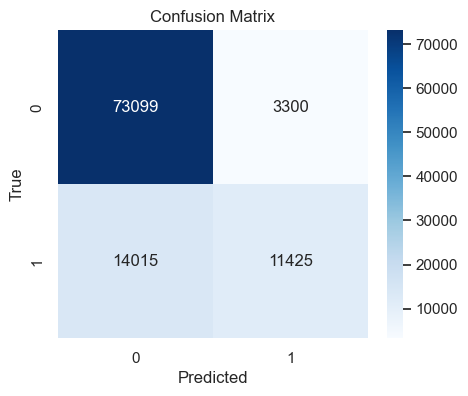

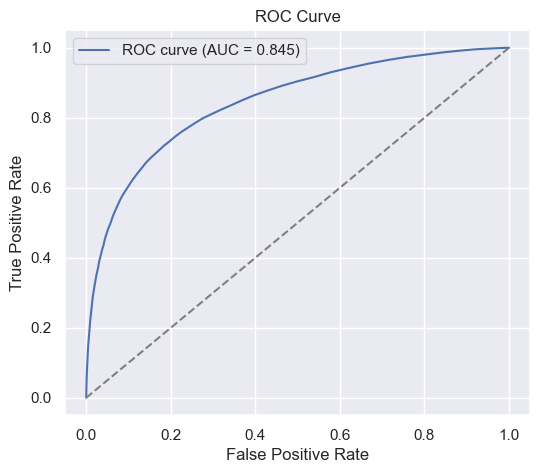

In [402]:
# Obtener predicciones con cross_val_predict (probabilidades para ROC)
y_pred = cross_val_predict(model, X, y, cv=skf, method='predict')
y_proba = cross_val_predict(model, X, y, cv=skf, method='predict_proba')[:,1]

# Mostrar reporte clasificación
print(classification_report(y, y_pred))

# Accuracy
acc = accuracy_score(y, y_pred)
print(f"Accuracy promedio CV: {acc:.4f}")

# Matriz de confusión
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y, y_proba)
auc_score = roc_auc_score(y, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [57]:
def run_grid_search(model, param_grid, name):
    print(f"\n🔍 Searching best params for: {name}")
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1, verbose=2)
    grid.fit(X, y)

    print(f"✅ Best params for {name}: {grid.best_params_}")
    print(f"📊 Best F1 score: {grid.best_score_:.4f}")
    return grid


In [58]:

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 4]
}

from xgboost import XGBClassifier

param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__scale_pos_weight': [2, 3]  # clase 1 minoritaria
}

lgbm_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1]
}


gb_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5]
}

In [65]:
grid_xgb = run_grid_search(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid_xgb, "XGBoost")


🔍 Searching best params for: XGBoost
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:43:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




✅ Best params for XGBoost: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 2}
📊 Best F1 score: 0.6496


In [406]:
grid_rf = run_grid_search(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid_rf, "Random Forest")
grid_xgb = run_grid_search(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid_xgb, "XGBoost")



🔍 Searching best params for: Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best params for Random Forest: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
📊 Best F1 score: 0.6379

🔍 Searching best params for: XGBoost
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[04:13:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




✅ Best params for XGBoost: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 2}
📊 Best F1 score: 0.6497


In [407]:
grid_lgbm=run_grid_search(LGBMClassifier(class_weight='balanced', random_state=42), lgbm_params, "LGBM")
grid_gb= run_grid_search(GradientBoostingClassifier(random_state=42), gb_params, 'GradientBoosting')


🔍 Searching best params for: LGBM
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 25440, number of negative: 76399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13128
[LightGBM] [Info] Number of data points in the train set: 101839, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [61]:
def evaluar_modelo_cv(modelo, X, y, skf, nombre="Modelo"):
    print(f"\n📊 Evaluación de: {nombre}")

    # Cross-validated predictions
    y_pred = cross_val_predict(modelo, X, y, cv=skf, method='predict')
    y_proba = cross_val_predict(modelo, X, y, cv=skf, method='predict_proba')[:, 1]

    # Matriz de confusión
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No popular", "Popular"], yticklabels=["No popular", "Popular"])
    plt.title(f"Matriz de Confusión: {nombre}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    # Reporte
    print("\n📋 Reporte de clasificación:")
    print(classification_report(y, y_pred))

    # ROC y AUC
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=nombre).plot()
    plt.tight_layout()
    plt.show()

    # Accuracy con desviación estándar
    scores = cross_val_score(modelo, X, y, cv=skf, scoring='accuracy')
    print(f"✅ Accuracy promedio: {scores.mean():.4f}")
    print(f"📈 Desviación estándar: {scores.std():.4f}")



📊 Evaluación de: Random Forest


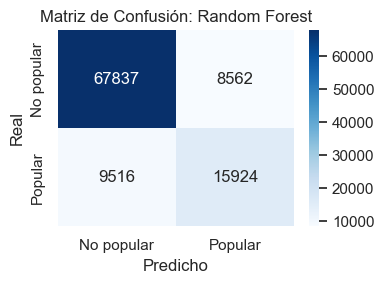


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     76399
           1       0.65      0.63      0.64     25440

    accuracy                           0.82    101839
   macro avg       0.76      0.76      0.76    101839
weighted avg       0.82      0.82      0.82    101839



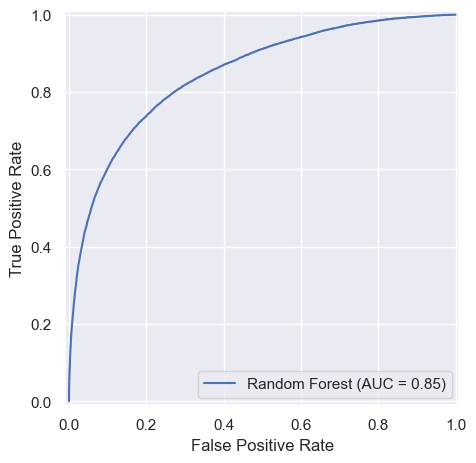

✅ Accuracy promedio: 0.8225
📈 Desviación estándar: 0.0033


In [409]:
evaluar_modelo_cv(grid_rf.best_estimator_, X, y, skf, nombre="Random Forest")


📊 Evaluación de: XGBoost


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:43:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:43:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:43:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:43:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:43:3

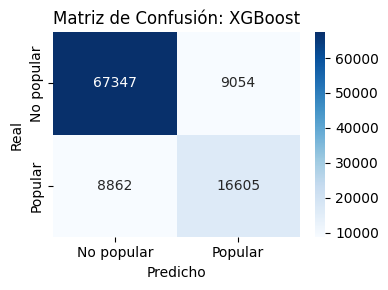


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     76401
           1       0.65      0.65      0.65     25467

    accuracy                           0.82    101868
   macro avg       0.77      0.77      0.77    101868
weighted avg       0.82      0.82      0.82    101868



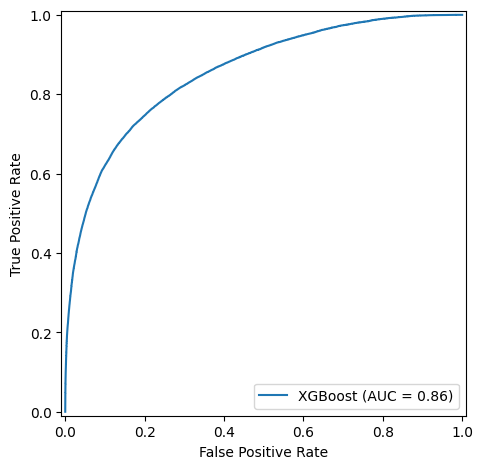

c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:43:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:43:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:44:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:44:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[05:44:0

✅ Accuracy promedio: 0.8241
📈 Desviación estándar: 0.0020


In [66]:

evaluar_modelo_cv(grid_xgb.best_estimator_, X, y, skf, nombre="XGBoost")


📊 Evaluación de: LGBM
[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13125
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13122
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13124
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13128
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13125
[LightGBM] [Info] Number of data points in the train set: 81472, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13125
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13122
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13124
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13128
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13125
[LightGBM] [Info] Number of data points in the train set: 81472, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



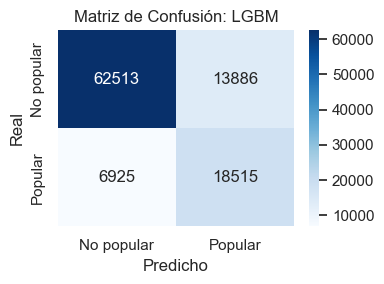


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     76399
           1       0.57      0.73      0.64     25440

    accuracy                           0.80    101839
   macro avg       0.74      0.77      0.75    101839
weighted avg       0.82      0.80      0.80    101839



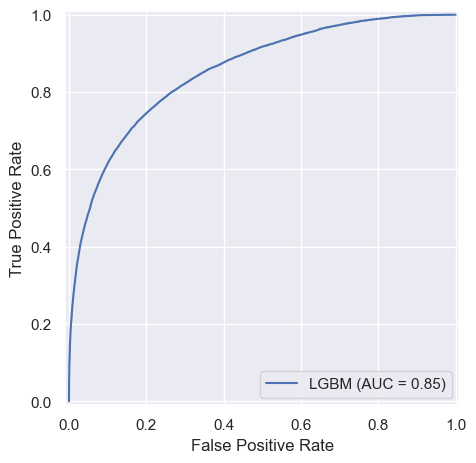

[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13125
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13122
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13124
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13128
[LightGBM] [Info] Number of data points in the train set: 81471, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 20352, number of negative: 61120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13125
[LightGBM] [Info] Number of data points in the train set: 81472, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



In [411]:
evaluar_modelo_cv(grid_lgbm.best_estimator_, X, y, skf, nombre="LGBM")


📊 Evaluación de: GradientBoosting


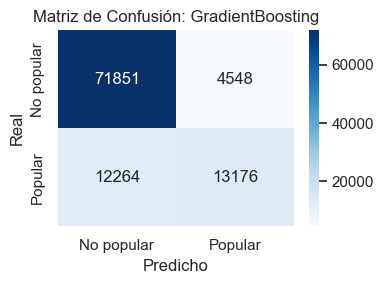


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.94      0.90     76399
           1       0.74      0.52      0.61     25440

    accuracy                           0.83    101839
   macro avg       0.80      0.73      0.75    101839
weighted avg       0.83      0.83      0.82    101839



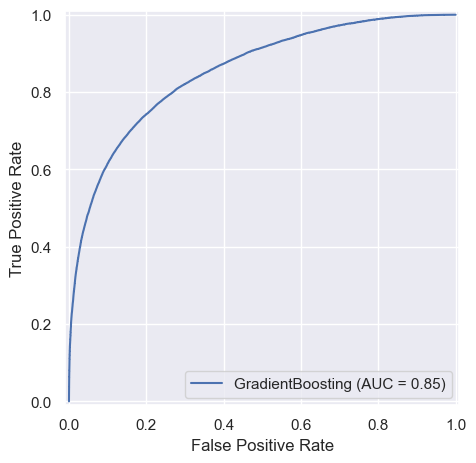

✅ Accuracy promedio: 0.8349
📈 Desviación estándar: 0.0011


In [412]:
evaluar_modelo_cv(grid_gb.best_estimator_, X, y, skf, nombre="GradientBoosting")


📊 Evaluación de: Bagging


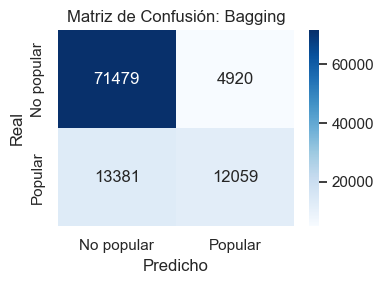


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     76399
           1       0.71      0.47      0.57     25440

    accuracy                           0.82    101839
   macro avg       0.78      0.70      0.73    101839
weighted avg       0.81      0.82      0.81    101839



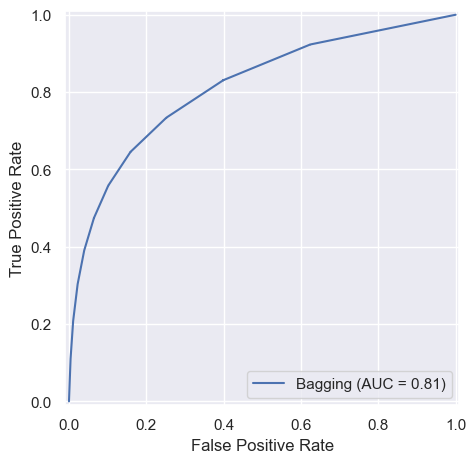

✅ Accuracy promedio: 0.8203
📈 Desviación estándar: 0.0026


In [413]:
bagging= Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(random_state=42))
])
evaluar_modelo_cv(bagging, X, y, skf, nombre="Bagging")


📊 Evaluación de: Voting


c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn

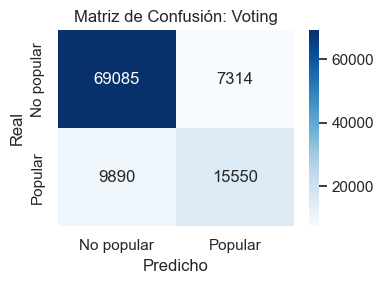


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     76399
           1       0.68      0.61      0.64     25440

    accuracy                           0.83    101839
   macro avg       0.78      0.76      0.77    101839
weighted avg       0.83      0.83      0.83    101839



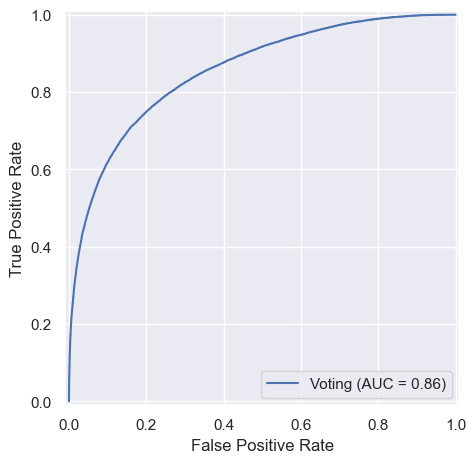

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\perez\Documents\cursomchl\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



✅ Accuracy promedio: 0.8311
📈 Desviación estándar: 0.0014


In [415]:
voting = VotingClassifier(
    estimators=[
        ('Bagging', bagging),
        ('Random forest', grid_rf.best_estimator_),
        ('lgbm', grid_lgbm.best_estimator_),
        ('gb', grid_gb.best_estimator_),
        ("xgb", grid_xgb.best_estimator_)
    ],
    voting='soft',
    n_jobs=-1
)
evaluar_modelo_cv(voting, X, y, skf, nombre="Voting")

In [ ]:

# Lista de resultados con métricas de ambas clases
resultados_modelos = [
    {
        'Modelo': 'Random Forest',
        'Accuracy': 0.8225,
        'Std': 0.0033,
        'ROC AUC': 0.85,
        'F1 clase 0': 0.88,
        'Recall clase 0': 0.89,
        'Precision clase 0': 0.88,
        'F1 clase 1': 0.64,
        'Recall clase 1': 0.63,
        'Precision clase 1': 0.65
    },
    {
        'Modelo': 'XGBoost',
        'Accuracy': 0.8243,
        'Std': 0.0017,
        'ROC AUC': 0.86,
        'F1 clase 0': 0.88,
        'Recall clase 0': 0.88,
        'Precision clase 0': 0.88,
        'F1 clase 1': 0.65,
        'Recall clase 1': 0.65,
        'Precision clase 1': 0.65
    },
    {
        'Modelo': 'LightGBM',
        'Accuracy': 0.7956,
        'Std': 0.0034,
        'ROC AUC': 0.85,
        'F1 clase 0': 0.86,
        'Recall clase 0': 0.82,
        'Precision clase 0': 0.90,
        'F1 clase 1': 0.64,
        'Recall clase 1': 0.73,
        'Precision clase 1': 0.57
    },
    {
        'Modelo': 'Gradient Boosting',
        'Accuracy': 0.8349,
        'Std': 0.0011,
        'ROC AUC': 0.85,
        'F1 clase 0': 0.90,
        'Recall clase 0': 0.94,
        'Precision clase 0': 0.85,
        'F1 clase 1': 0.61,
        'Recall clase 1': 0.52,
        'Precision clase 1': 0.74
    },
    {
        'Modelo': 'Bagging',
        'Accuracy': 0.8203,
        'Std': 0.0026,
        'ROC AUC': 0.81,
        'F1 clase 0': 0.89,
        'Recall clase 0': 0.94,
        'Precision clase 0': 0.84,
        'F1 clase 1': 0.57,
        'Recall clase 1': 0.47,
        'Precision clase 1': 0.71
    },
    {
        'Modelo': 'Voting',
        'Accuracy': 0.8311,
        'Std': 0.0017,
        'ROC AUC': 0.86,
        'F1 clase 0': 0.89,
        'Recall clase 0': 0.90,
        'Precision clase 0': 0.87,
        'F1 clase 1': 0.64,
        'Recall clase 1': 0.61,
        'Precision clase 1': 0.68
    }
]

# Crear DataFrame
df_resultados = pd.DataFrame(resultados_modelos)

# Ordenar por ROC AUC o la métrica que prefieras
df_resultados = df_resultados.sort_values(by='ROC AUC', ascending=False)

# Reiniciar índice y mostrar
df_resultados.reset_index(drop=True, inplace=True)


# Resultados

In [437]:
df_resultados.T

,0,1,2,3,4,5
Modelo,XGBoost,Voting,Random Forest,LightGBM,Gradient Boosting,Bagging
Accuracy,0.8243,0.8311,0.8225,0.7956,0.8349,0.8203
Std,0.0017,0.0017,0.0033,0.0034,0.0011,0.0026
ROC AUC,0.86,0.86,0.85,0.85,0.85,0.81
F1 clase 0,0.88,0.89,0.88,0.86,0.9,0.89
Recall clase 0,0.88,0.9,0.89,0.82,0.94,0.94
Precision clase 0,0.88,0.87,0.88,0.9,0.85,0.84
F1 clase 1,0.65,0.64,0.64,0.64,0.61,0.57
Recall clase 1,0.65,0.61,0.63,0.73,0.52,0.47
Precision clase 1,0.65,0.68,0.65,0.57,0.74,0.71


C:\Users\perez\AppData\Local\Temp\ipykernel_4036\4021292831.py:32: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.

c:\Users\perez\Documents\cursomchl\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.



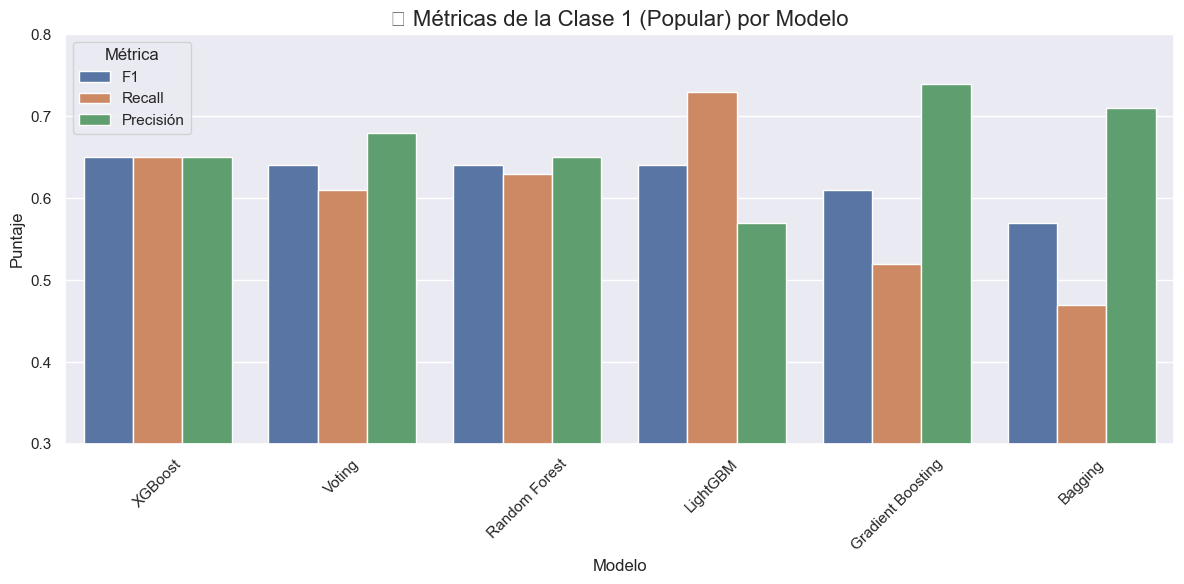

In [ ]:

# Estilo visual
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Derretir el DataFrame para formato largo (tidy) — necesario para seaborn
df_melted = df_resultados.melt(
    id_vars='Modelo',
    value_vars=['F1 clase 1', 'Recall clase 1', 'Precision clase 1'],
    var_name='Métrica',
    value_name='Valor'
)

# Mapa de nombres más legibles (opcional)
df_melted['Métrica'] = df_melted['Métrica'].map({
    'F1 clase 1': 'F1',
    'Recall clase 1': 'Recall',
    'Precision clase 1': 'Precisión'
})

# Crear gráfico de barras agrupadas
sns.barplot(data=df_melted, x='Modelo', y='Valor', hue='Métrica')

# Estética
plt.title('🔍 Métricas de la Clase 1 (Popular) por Modelo', fontsize=16)
plt.ylabel('Puntaje')
plt.xticks(rotation=45)
plt.ylim(0.3, 0.8)  # Ajusta si quieres otro rango
plt.legend(title='Métrica')
plt.tight_layout()
plt.show()


### Modelo elegido: XBG

In [56]:
# Paso 1: Variables numéricas (sin texto, ni objetivo)
num_features = [col for col in df_clean.columns if col not in ['Short description', 'is_popular', 'AppID', 'Short description']]

# Paso 2: Definir transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

text_transformer = TfidfVectorizer(max_features=50)  # Ajusta max_features según tamaño dataset y potencia

# Paso 3: Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('text', text_transformer, 'Short description')
    ],
    remainder='drop'
)
model_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, learning_rate= 0.1, max_depth= 6, n_estimators= 100, scale_pos_weight= 2))
])

In [57]:
# 👇 Entrenamos el pipeline completo (si aún no lo hiciste)
model_xgb.fit(X, y)

# 🔍 Luego extraemos de nuevo el preprocessor y el modelo ya entrenado
preprocessor_xgb = model_xgb.named_steps['preprocessor']
xgb_model = model_xgb.named_steps['classifier']

# 🔄 Volvemos a transformar los datos
X_transformed = preprocessor_xgb.transform(X)

# 📛 Obtener nombres de columnas (mismo procedimiento)
num_names = list(preprocessor_xgb.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(input_features=num_features))
text_names = list(preprocessor_xgb.named_transformers_['text'].get_feature_names_out())
all_feature_names = num_names + text_names

# 📊 Importancias ya accesibles
importances =xgb_model.feature_importances_

# ✅ Verificación y visualización
if len(importances) != len(all_feature_names):
    raise ValueError("El número de columnas transformadas no coincide con el número de importancias del modelo.")

importancia_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 📌 Mostrar top 20
importancia_df.head(30)



c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:08:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




,feature,importance
51,release_year,0.125944
21,Steam Cloud,0.091945
3,Price,0.068700
17,Other_cat,0.053262
8,Free to Play,0.048841
41,Logros_Sin logros,0.034346
11,RPG,0.025118
43,Logros_Moderados,0.021900
42,Logros_Pocos,0.020857
6,Casual,0.017392


In [421]:
def calculate_psi(expected, actual, bins=10):
    """
    Calcula el PSI entre dos distribuciones (expected vs actual).
    :param expected: Distribución base (e.g., entrenamiento)
    :param actual: Distribución nueva (e.g., producción)
    :param bins: Número de bins (percentiles)
    :return: Valor PSI
    """
    expected = np.array(expected)
    actual = np.array(actual)

    # Evitar bins duplicados
    try:
        breakpoints = np.unique(np.percentile(expected, np.linspace(0, 100, bins + 1)))
        if len(breakpoints) - 1 < bins:
            bins = len(breakpoints) - 1
    except Exception as e:
        raise ValueError(f"Error generando breakpoints: {e}")

    expected_counts, _ = np.histogram(expected, bins=breakpoints)
    actual_counts, _ = np.histogram(actual, bins=breakpoints)

    expected_percents = expected_counts / len(expected)
    actual_percents = actual_counts / len(actual)

    # Evitar log(0) o división por cero
    expected_percents = np.where(expected_percents == 0, 1e-6, expected_percents)
    actual_percents = np.where(actual_percents == 0, 1e-6, actual_percents)

    psi_values = (actual_percents - expected_percents) * np.log(actual_percents / expected_percents)
    psi = np.sum(psi_values)

    return psi


In [ ]:

X_expected, X_actual = train_test_split(X, test_size=0.2, random_state=42)

# Paso 2: Transforma con el preprocessor final ya entrenado
X_expected_trans = preprocessor_xgb.transform(X_expected)
X_actual_trans = preprocessor_xgb.transform(X_actual)

psi_results = []

for i, feature_name in enumerate(all_feature_names):
    psi_value = calculate_psi(X_expected_trans[:, i], X_actual_trans[:, i])
    psi_results.append((feature_name, psi_value))

# DataFrame con los PSI
psi_df = pd.DataFrame(psi_results, columns=["feature", "psi"]).sort_values(by="psi", ascending=False)
print(psi_df.head(25))  # Mostrar las features con mayor drift



             feature       psi
103              you  0.000773
53       release_day  0.000689
52     release_month  0.000561
95                to  0.000350
59               and  0.000340
75                in  0.000301
80                of  0.000285
51      release_year  0.000235
3              Price  0.000217
54   release_quarter  0.000203
104             your  0.000154
90               the  0.000148
60               are  0.000144
77                is  0.000115
101             with  0.000095
61                as  0.000088
102            world  0.000076
92              this  0.000039
64                by  0.000033
100             will  0.000027
89              that  0.000020
98             where  0.000018
78                it  0.000014
58                an  0.000010
71              game  0.000006


In [ ]:

# Dividir el dataset (ajusta según el nombre de tu variable temporal y target)
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df_pr, test_size=0.3, stratify=y, random_state=42
)


In [425]:
model_xgb.fit(X_train, y_train)


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[09:00:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Windows', 'Mac', 'Linux',
                                                   'Price', 'Action',
                                                   'Adventure', 'Casual',
                                                   'Early Access',
                                                   'Free to Play', 'Indie',
                                                   'Other_genre', 'RPG',
                                                   'Simulation', 'Strategy',
                                                   'Family Sharing',
                                                   'Full controller support',
                                                   'Multi...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [426]:
df_train = df_train.copy()
df_test = df_test.copy()

df_train['pred'] = model_xgb.predict_proba(X_train)[:, 1]
df_test['pred'] = model_xgb.predict_proba(X_test)[:, 1]


In [427]:
train_preds = df_train['pred']
psi_por_periodo = []

# Ajusta esto al nombre real de tu columna temporal, por ejemplo 'Release year'
for periodo, grupo in df_test.groupby('release_year'):
    psi = calculate_psi(train_preds, grupo['pred'])
    psi_por_periodo.append((str(periodo), psi))

df_psi = pd.DataFrame(psi_por_periodo, columns=['Periodo', 'PSI'])


In [428]:
df_psi

,Periodo,PSI
0,2006,12.433756
1,2007,11.191477
2,2008,9.674053
3,2009,11.010061
4,2010,7.465568
5,2011,10.118794
6,2012,11.262860
7,2013,11.175626
8,2014,10.056475
9,2015,6.078165


In [ ]:

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_psi['Periodo'],
    y=df_psi['PSI'],
    mode='lines+markers',
    name='PSI',
    marker=dict(color='blue')
))

# Límites como líneas horizontales
fig.add_hline(y=0.1, line_dash='dash', line_color='orange', annotation_text='Límite leve', annotation_position='top left')
fig.add_hline(y=0.25, line_dash='dash', line_color='red', annotation_text='Límite severo', annotation_position='top left')

fig.update_layout(
    title='PSI por periodo',
    xaxis_title='Periodo',
    yaxis_title='PSI',
    xaxis_tickangle=-45,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    template='plotly_white',
    height=500,
    width=900,
)

fig.show()


In [ ]:

df_all = df_pr.copy()
df_all['pred_proba'] = model_xgb.predict_proba(X)[:, 1]
df_all['pred_bin'] = (df_all['pred_proba'] > 0.5).astype(int)

resultados = []

for año, grupo in df_all.groupby('release_year'):
    #if grupo['is_popular'].nunique() < 2:
        #continue

    y_true = grupo['is_popular']
    y_proba = grupo['pred_proba']
    y_pred_bin = grupo['pred_bin']

    # KS: comparar distribuciones de predicciones entre clases 0 y 1
    proba_0 = y_proba[y_true == 0]
    proba_1 = y_proba[y_true == 1]

    if len(proba_0) > 0 and len(proba_1) > 0:
        ks_stat = ks_2samp(proba_0, proba_1).statistic
    else:
        ks_stat = np.nan

    resultados.append({
        'año': año,
        'n': len(grupo),
        'auc': roc_auc_score(y_true, y_proba),
        'f1': f1_score(y_true, y_pred_bin),
        'ks': ks_stat
    })

df_metricas = pd.DataFrame(resultados).sort_values(by='año')


In [432]:
df_metricas

,año,n,auc,f1,ks
0,2006,63,1.000000,0.992000,1.000000
1,2007,98,1.000000,0.989691,1.000000
2,2008,164,0.877778,0.938111,0.741667
3,2009,322,0.888615,0.919192,0.675039
4,2010,284,0.899856,0.900000,0.696472
5,2011,265,0.943883,0.962376,0.785447
6,2012,333,0.781931,0.970634,0.521958
7,2013,441,0.896781,0.980347,0.759711
8,2014,1587,0.816470,0.923234,0.481072
9,2015,2586,0.812527,0.844732,0.462699


In [ ]:


# Asegurar que 'año' sea tratado como categoría ordenada si es necesario
df_metricas_sorted = df_metricas.sort_values(by='año')

fig = go.Figure()

# KS
fig.add_trace(go.Scatter(
    x=df_metricas_sorted['año'], y=df_metricas_sorted['ks'],
    mode='lines+markers',
    name='KS',
    line=dict(color='green')
))

# ROC AUC
fig.add_trace(go.Scatter(
    x=df_metricas_sorted['año'], y=df_metricas_sorted['auc'],
    mode='lines+markers',
    name='ROC AUC',
    line=dict(color='blue')
))

# F1 Score
fig.add_trace(go.Scatter(
    x=df_metricas_sorted['año'], y=df_metricas_sorted['f1'],
    mode='lines+markers',
    name='F1-score',
    line=dict(color='purple')
))

# Líneas de referencia
fig.add_hline(y=0.2, line=dict(dash='dash', color='orange'), annotation_text='KS mínimo aceptable', annotation_position='top left')
fig.add_hline(y=0.4, line=dict(dash='dash', color='gray'), annotation_text='KS buen desempeño', annotation_position='top left')

# Configuración general
fig.update_layout(
    title="Evolución Interactiva de KS, ROC AUC y F1 por Año",
    xaxis_title="Año de Lanzamiento",
    yaxis_title="Valor de Métrica",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()


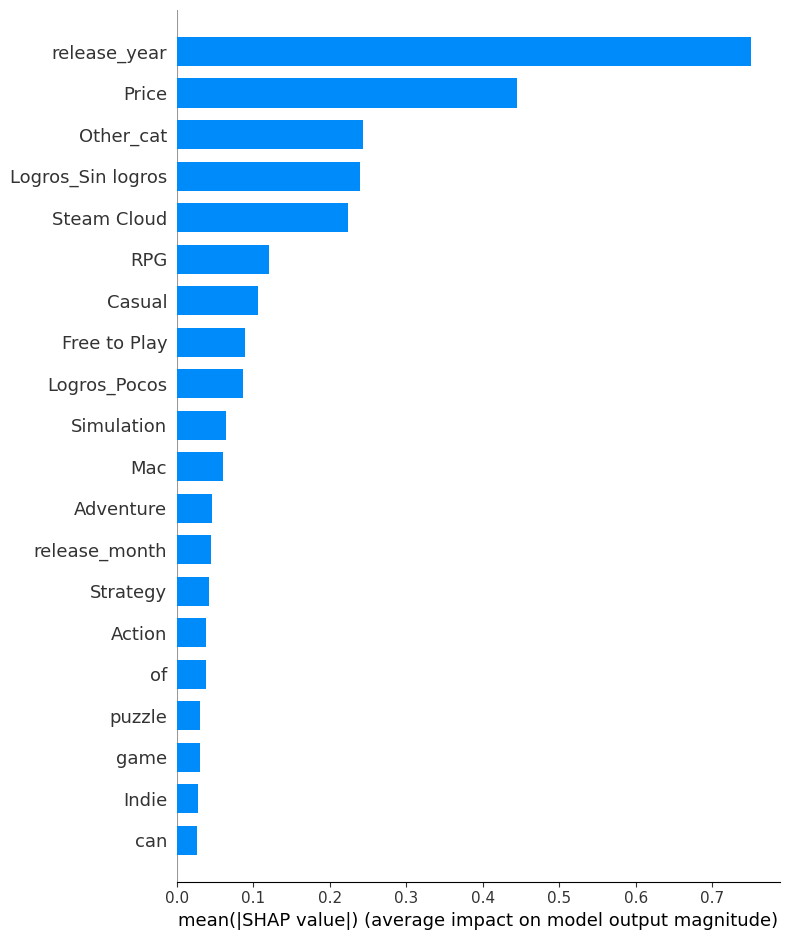

In [59]:
import shap

# 👉 Crear el explainer con el modelo ya entrenado
explainer = shap.Explainer(xgb_model)

# 👉 SHAP values (usamos los datos transformados del pipeline)
shap_values = explainer(X_transformed)

# 🔍 Visualización global: summary plot (bar chart)
shap.summary_plot(shap_values, X_transformed, feature_names=all_feature_names, plot_type='bar')


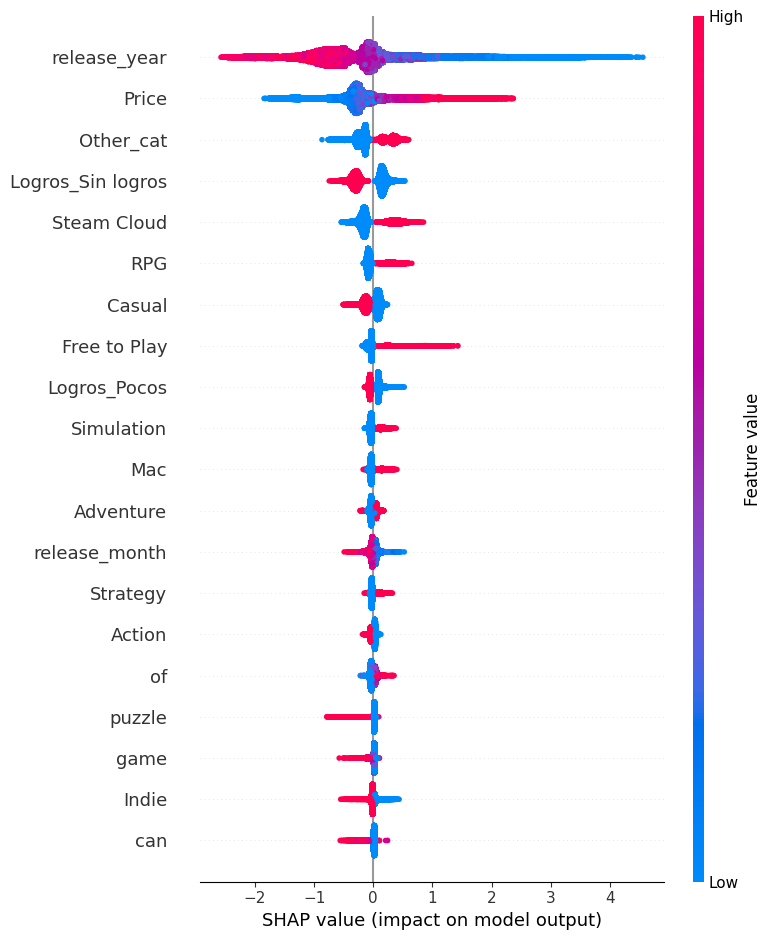

In [61]:
# 🔍 Visualización detallada: summary plot tipo "beeswarm"
shap.summary_plot(shap_values, X_transformed, feature_names=all_feature_names)



In [63]:
import shap

# Activar JS para entorno Jupyter (puedes omitirlo si no estás en Jupyter)
shap.initjs()

# 👉 Crear el force plot correctamente
shap.force_plot(
    base_value=shap_values.base_values[0],      # valor base
    shap_values=shap_values.values[0],          # shap values para la obs 0
    features=X_transformed[0],                  # valores de features transformadas
    feature_names=all_feature_names
)
